In [2]:
import pandas as pd

from tqdm.notebook import tqdm

In [3]:
def create_dataset(data, index):
    # кол-во уникальных номеров <= median?  <= mean? 

    id2unique_numbers = data.groupby('id_a')['id_b'].nunique()

    d1 = (id2unique_numbers <= id2unique_numbers.median()).to_dict()
    index["unique_calls_meadian"] = index.id.map(d1)

    d2 = (id2unique_numbers <= id2unique_numbers.mean()).to_dict()
    index["unique_calls_mean"] = index.id.map(d2)

    del d1
    del d2

    # кол-во звонков всего <= median?  <= mean? 
    id2_numbers = data.groupby("id_a").id_b.count()

    d1 = (id2_numbers <= id2_numbers.median()).to_dict()
    index["calls_meadian"] = index.id.map(d1)

    d2 = (id2_numbers <= id2_numbers.mean()).to_dict()
    index["calls_mean"] = index.id.map(d2)

    del d1
    del d2

    # доля звонков с нулевой продолжительностью, кол-во звонков с нулевой продолжительностью <= median? <= mean?
    zero_duration = data.loc[data.duration == 0].groupby("id_a").duration.count()
    d1 = (zero_duration <= zero_duration.median()).to_dict()
    index["zero_duration_median"] = index.id.map(d1).fillna(0)

    d2 = (zero_duration <= zero_duration.mean()).to_dict()
    index["zero_duration_mean"] = index.id.map(d2).fillna(0)

    del d1
    del d2

    zero_duration = zero_duration.to_dict()
    index["zero_duration_frac"] = index.id.map(zero_duration).fillna(0)
    index["zero_duration_frac"] = index["zero_duration_frac"] / index.id.map(id2_numbers.to_dict())

    # звонил ли на один и тот же номер несколько раз?
    index["multi_calls"] = index.id.map((id2unique_numbers == id2_numbers).to_dict())
    
    # кол-во разных поясов number_of_time_zones
    index["number_of_time_zones"] = index.id.map(data.groupby("id_a").time_zone.nunique().to_dict())

    # среднее / максимальное время звонка
    index["mean_call_duration"] = index.id.map(data.groupby("id_a").duration.mean().to_dict())
    index["max_call_duration"] = index.id.map(data.groupby("id_a").duration.max().to_dict())

    # forward доля
    index["forward_frac"] = index.id.map(data.groupby("id_a").forward.sum().to_dict())
    index["forward_frac"] = index["forward_frac"] / index.id.map(id2_numbers.to_dict())

    # zero_call_flg посчитать доли классов 
    index = index.merge(data.groupby(['id_a', 'zero_call_flg']).size().unstack(fill_value=0), left_on='id', right_on='id_a', how='left')
    fancy_names = {i : "zero_call_flg_" + str(i) for i in range(6)}
    index.rename(columns=fancy_names, inplace=True)

    for key, column in fancy_names.items():
        index[column] = index[column] / index.id.map(id2_numbers.to_dict())

    # (source_b, source_f) доли пар, доли по отдельности

    data_sources = data.groupby(['id_a', 'source_b', "source_f"]).size().unstack(fill_value=0).unstack(fill_value=0)
    for col_name, ind in [("source_00_frac", (False, False)), ("source_01_frac", (False, True)), ("source_11_frac", (True, True)), ("source_10_frac", (True, False))]:
        index[col_name] = index.id.map(data_sources.loc[:, ind].to_dict()) / index.id.map(id2_numbers.to_dict())


    index["source_b_frac"] = index.id.map(data.groupby("id_a").source_b.sum().to_dict())
    index["source_b_frac"] = index["source_b_frac"] / index.id.map(id2_numbers.to_dict())

    index["source_f_frac"] = index.id.map(data.groupby("id_a").source_f.sum().to_dict())
    index["source_f_frac"] = index["source_f_frac"] / index.id.map(id2_numbers.to_dict())

    # медиана, мода часа когда звонил человек
    data["hour"] = data["date"].dt.hour
    index["median_hour"] = index.id.map(data.groupby("id_a").hour.median().to_dict())
    index["mode_hour"] = index.id.map(data.groupby("id_a").hour.agg(pd.Series.mode).to_dict())
    
    # доля звонков ночью
    data["hour"] = (data["hour"] >= 0) & (data["hour"] <= 6)
    index["night_call(kavinsky)"] = index.id.map(data.groupby("id_a").hour.mean().to_dict())

    # доля звонков днем
    data["hour"] = data["date"].dt.hour
    data["hour"] = (data["hour"] > 6) & (data["hour"] <= 10)
    index["morning_call"] = index.id.map(data.groupby("id_a").hour.mean().to_dict())
    
    # доля активных дней за срок
    data.date = data.date.dt.normalize()
    index["active_days_frac"] = index.id.map(data.groupby("id_a").date.nunique())
    index["active_days_frac"] = index["active_days_frac"] / data.date.nunique()

    return index


index = pd.read_csv("/content/drive/MyDrive/hackathon/beeline_antispam_hakaton_id_samples.csv")
id2index = {id: ind for ind, id in enumerate(index['id'].unique())}
index2id = {ind: id for id, ind in id2index.items()}
index['id'] = index['id'].map(id2index)

**Посчитаем фичи по первому и по второму месяцу отдельно:**

In [3]:
# датасет по первому месяцу
data = pd.read_pickle("/content/drive/MyDrive/user_data/data/first_month")
index = create_dataset(data, index)
index.to_csv("/content/drive/MyDrive/one_mounth_data.csv", index=None)

In [3]:
# датасет по второму месяцу
data = pd.read_pickle("/content/drive/MyDrive/user_data/data/second_month")
index = create_dataset(data, index)
index.to_csv("/content/drive/MyDrive/second_mounth_data.csv", index=None)

**Добавим фичу "пользователю кто-то звонил" (т.е. данный id_a представлен для какого-то id_a' как id_b)**

In [4]:
our_ids = [val for key, val in index2id.items()]

data = pd.read_csv("/content/drive/MyDrive/one_mounth_data.csv")
data["id_get_inverse_call"] = False
first =  pd.read_pickle("/content/drive/MyDrive/user_data/data/first_month")
id_get_inverse_call = first.loc[first.id_b.isin(our_ids)].id_b.map(id2index)
data.loc[data.id.isin(id_get_inverse_call), "id_get_inverse_call"] = True
data.to_csv("/content/drive/MyDrive/one_mounth_data.csv", index=None)

second = pd.read_pickle("/content/drive/MyDrive/user_data/data/second_month")
id_get_inverse_call = second.loc[second.id_b.isin(our_ids)].id_b.map(id2index)
data = pd.read_csv("/content/drive/MyDrive/second_mounth_data.csv")
data["id_get_inverse_call"] = False
data.loc[data.id.isin(id_get_inverse_call), "id_get_inverse_call"] = True
data.to_csv("/content/drive/MyDrive/second_mounth_data.csv", index=None)

**Объеденим данные по датасету следующим образом: Данные по первому месяцу заполняют всех пользователей, которые совершали звонки в этот период, данные по второму месяцу заполняют всех пользователей, по которым не было данных в первый месяц**


**У людей, которые были активны и первый и второй месяц, первый месяц идет в датасет для обучения  и предикта, второй в датасет, на котором будет проверятся стабильность алгоритма**

In [25]:
first = pd.read_csv("/content/drive/MyDrive/one_mounth_data.csv")
second = pd.read_csv("/content/drive/MyDrive/second_mounth_data.csv")
first.multi_calls = first.multi_calls.fillna(0)
second.multi_calls = second.multi_calls.fillna(0)

In [26]:
missing_ids = first.loc[first.unique_calls_meadian.isnull()].id
possible_to_fill = second.loc[second.id.isin(missing_ids) & (~second.unique_calls_meadian.isnull())].id
first.loc[first.id.isin(possible_to_fill)] = second.loc[second.id.isin(possible_to_fill)]
stability_check_df = second.loc[(~second.id.isin(missing_ids)) & (~second.unique_calls_meadian.isnull())]
first.to_csv("/content/drive/MyDrive/user_data_by_one_month.csv", index=None)
stability_check_df.to_csv("/content/drive/MyDrive/stability_check_df.csv", index=None)

**Метрика стабильности, которой подаются предсказания модели, основанные на разных временных интервалах. Лучшее значение 0, худшее 3. (считать ее будем потом)**

Измеряется так: последовательно смотрятся для всех пользователей старое и новое значение, при этом суммируется индикатор, что они изменились.
При этом изменение: 


0 <-> 4, 3 - С коэф. очень плохо


0 <-> 1, 2 - с коэф. так себе плохо


1 <-> 2, 3 <-> 4 с дисконтом


(1, 2) <-> (3, 4) c коэф. средне плохо


Стоит отметить, что такой замер стабильности модели подходит, если мы четко можем понять момент, когда сменился владелец номера. Если же это не так, то наша "нестабильность" будет говорить о том, что модель умеет находить аномальное поведение (если проверить это на валидации :)) (наверное)


In [5]:
def stability_score(y_old, y_new, params={"дисконт": 0.5, "так себе плохо": 1, "средне плохо": 2, "очень плохо": 3}):
    result = 0.0
    size = 0
    changes = {"очень плохо" : [(0, 4), (4, 0), (0, 3), (3, 0)],
               "так себе плохо" : [(2, 0), (1, 0), (0, 1), (0, 2)], "дисконт" : [(2, 1), (1, 2), (3, 4), (4, 3)]}
    for y1, y2 in zip(y_old, y_new):
        if y1 != y2:
            pair = (y1, y2)
            if pair in changes["очень плохо"]:
                result += params["очень плохо"]
            elif pair in changes["дисконт"]:
                result += params["дисконт"]
            elif pair in changes["так себе плохо"]:
                result += params["так себе плохо"]
            else:
                result += params["средне плохо"]
        size += 1
    return result / size

In [6]:
stability_score([4], [4]), stability_score([0], [4]), stability_score([4, 4, 4, 4], [0, 0, 4, 4])

(0.0, 3.0, 1.5)

**Сделаем предикт кетбуст классификатором**

In [77]:
!pip install catboost

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [181]:
data = pd.read_csv("/content/drive/MyDrive/user_data_by_one_month.csv")
data.drop(columns="source_00_frac", inplace=True)
data = data.replace("True", 1)
data = data.replace("False", 0)
data.loc[data.mode_hour.apply(lambda x : len(x) if type(x) != float else 0) > 3, "mode_hour"] = -1

test = data.loc[data.split == "test"].drop(columns=["split", "target"])
train = data.loc[data.split == "train"].drop(columns="split")
test["y"] = 0
train = train.loc[~train.unique_calls_meadian.isnull()]

In [182]:
train, val = train_test_split(train, test_size=0.25, random_state=42)

In [183]:
train.shape, val.shape

((21234, 31), (7079, 31))

In [184]:
val.loc[val.unique_calls_meadian.isnull()].shape[0] / val.shape[0],test.loc[test.unique_calls_meadian.isnull()].shape[0] / test.shape[0]

(0.0, 0.23566125040352953)

In [185]:
y_train = train.target
y_val = val.target
train.drop(columns=["id", "target"], inplace=True)
val.drop(columns=["id", "target"], inplace=True)
# val.drop(columns="id", inplace=True)

In [186]:
category_columns = ["mode_hour"]
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype(float).fillna(0).astype(int)
        val[col] = val[col].astype(float).fillna(0).astype(int)
        test[col] = test[col].astype(float).fillna(0).astype(int)
for col in category_columns:
    train[col] = train[col].fillna(-100).astype(str)
    val[col] = val[col].fillna(-100).astype(str)
    test[col] = test[col].fillna(-100).astype(str)

In [187]:
model = CatBoostClassifier(iterations=10000, auto_class_weights="Balanced", learning_rate=0.01, custom_metric="F:beta=0.5")
model.fit(
    train,
    y=y_train.values,
    eval_set=(val, y_val), 
    early_stopping_rounds=100, 
    cat_features=category_columns,
)

0:	learn: 1.5997827	test: 1.5996778	best: 1.5996778 (0)	total: 105ms	remaining: 17m 31s
1:	learn: 1.5887833	test: 1.5885623	best: 1.5885623 (1)	total: 210ms	remaining: 17m 28s
2:	learn: 1.5793484	test: 1.5791702	best: 1.5791702 (2)	total: 334ms	remaining: 18m 34s
3:	learn: 1.5691485	test: 1.5690326	best: 1.5690326 (3)	total: 446ms	remaining: 18m 34s
4:	learn: 1.5598623	test: 1.5596916	best: 1.5596916 (4)	total: 551ms	remaining: 18m 21s
5:	learn: 1.5508375	test: 1.5507012	best: 1.5507012 (5)	total: 661ms	remaining: 18m 20s
6:	learn: 1.5417337	test: 1.5417154	best: 1.5417154 (6)	total: 775ms	remaining: 18m 25s
7:	learn: 1.5338221	test: 1.5337810	best: 1.5337810 (7)	total: 881ms	remaining: 18m 20s
8:	learn: 1.5252770	test: 1.5253622	best: 1.5253622 (8)	total: 987ms	remaining: 18m 15s
9:	learn: 1.5167397	test: 1.5168501	best: 1.5168501 (9)	total: 1.09s	remaining: 18m 11s
10:	learn: 1.5080601	test: 1.5083650	best: 1.5083650 (10)	total: 1.21s	remaining: 18m 21s
11:	learn: 1.5000233	test: 1.5

**Построим confusion matrix и посчитаем F_{0.5} скор модели Кетбуста на валидации**

In [188]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

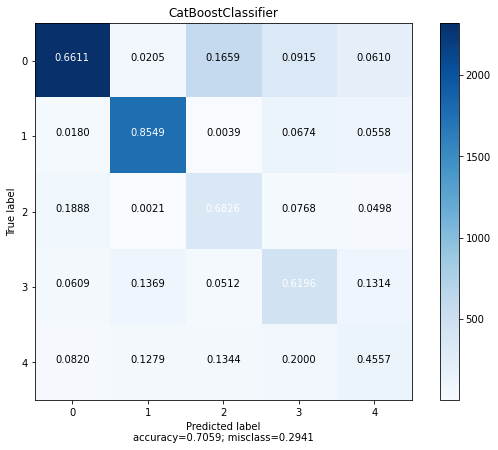

In [189]:
y_pred0 = model.predict(val)
mcm = confusion_matrix(y_val, model.predict(val), labels = y_val.unique())

plot_confusion_matrix(
    cm=mcm,  # confusion matrix created by
    # sklearn.metrics.confusion_matrix
    normalize=True,  # show proportions
    target_names=None,  # list of names of the classes
    title="CatBoostClassifier",
)

In [190]:
print(fbeta_score(model.predict(val), y_val, average='macro', beta=0.5), accuracy_score(model.predict(val), y_val))

0.6169278927035924 0.7058906625229552


**Посмотрим на KNN для определения спам(класс 1)/не спам(класс 0)**

In [134]:
y_train[y_train != 0] = 1
y_val[y_val != 0] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
model1 = KNeighborsClassifier(n_neighbors=5)

In [137]:
model1.fit(train, y_train)

KNeighborsClassifier()

In [138]:
y_pred1 = model1.predict(val)

In [140]:
print(fbeta_score(y_pred1, y_val, average='macro', beta=0.5), accuracy_score(y_pred1, y_val))


0.7490797797640016 0.7491171069360079


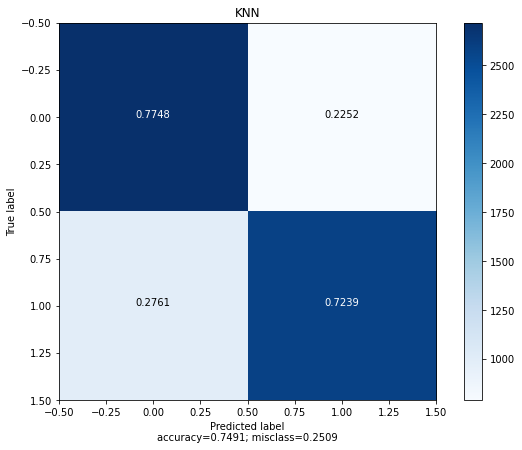

In [141]:
mcm = confusion_matrix(y_val, y_pred1, labels = y_val.unique())

plot_confusion_matrix(cm           = mcm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = None,       # list of names of the classes
                          title        = "KNN")

**Посмотрим в этом контексте на Кетбуст**

In [142]:
model = CatBoostClassifier(iterations=10000, auto_class_weights="Balanced", learning_rate=0.01, custom_metric ="F:beta=0.5")
model.fit(train, y=y_train.values, eval_set=(val, y_val), 
                 early_stopping_rounds=100, 
                 cat_features=category_columns)

0:	learn: 0.6853479	test: 0.6853209	best: 0.6853209 (0)	total: 81.2ms	remaining: 13m 31s
1:	learn: 0.6770819	test: 0.6769027	best: 0.6769027 (1)	total: 140ms	remaining: 11m 39s
2:	learn: 0.6698812	test: 0.6695609	best: 0.6695609 (2)	total: 212ms	remaining: 11m 47s
3:	learn: 0.6630841	test: 0.6627372	best: 0.6627372 (3)	total: 288ms	remaining: 12m
4:	learn: 0.6555898	test: 0.6551237	best: 0.6551237 (4)	total: 348ms	remaining: 11m 35s
5:	learn: 0.6488588	test: 0.6482479	best: 0.6482479 (5)	total: 425ms	remaining: 11m 48s
6:	learn: 0.6423970	test: 0.6416464	best: 0.6416464 (6)	total: 514ms	remaining: 12m 13s
7:	learn: 0.6352663	test: 0.6344016	best: 0.6344016 (7)	total: 580ms	remaining: 12m 4s
8:	learn: 0.6291803	test: 0.6282490	best: 0.6282490 (8)	total: 631ms	remaining: 11m 40s
9:	learn: 0.6236101	test: 0.6226480	best: 0.6226480 (9)	total: 712ms	remaining: 11m 51s
10:	learn: 0.6174346	test: 0.6163985	best: 0.6163985 (10)	total: 796ms	remaining: 12m 2s
11:	learn: 0.6120664	test: 0.610976

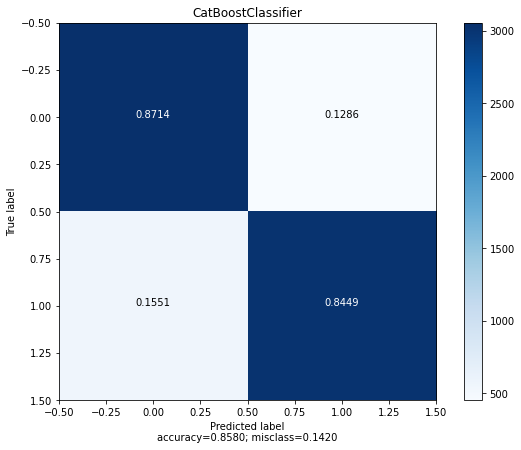

In [143]:
y_pred0 = model.predict(val)
mcm = confusion_matrix(y_val, model.predict(val), labels = y_val.unique())

plot_confusion_matrix(cm           = mcm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = None,       # list of names of the classes
                          title        = "CatBoostClassifier")

In [144]:
print(fbeta_score(y_pred0, y_val, average='macro', beta=0.5), accuracy_score(y_pred0, y_val))


0.8580563336349694 0.8580307953100721


**Обучим модель на всех данных и сделаем предсказание**

In [145]:
data = pd.read_csv("/content/drive/MyDrive/user_data_by_one_month.csv")
data.drop(columns="source_00_frac", inplace=True)
data = data.replace("True", 1)
data = data.replace("False", 0)
data.loc[data.mode_hour.apply(lambda x : len(x) if type(x) != float else 0) > 3, "mode_hour"] = -1

test, train = data.loc[data.split == "test"].drop(columns=["split", "target"]), data.loc[data.split == "train"].drop(columns="split")
test["y"] = 0
train = train.loc[~train.unique_calls_meadian.isnull()]
y_train = train.target
train.drop(columns=["id", "target"], inplace=True)

category_columns = ["mode_hour"]
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype(float).fillna(0).astype(int)
        test[col] = test[col].astype(float).fillna(0).astype(int)
for col in category_columns:
    train[col] = train[col].fillna(-100).astype(str)
    test[col] = test[col].fillna(-100).astype(str)

model = CatBoostClassifier(iterations=3300, auto_class_weights="Balanced", learning_rate=0.01)
model.fit(train, y=y_train.values, cat_features=category_columns)

0:	learn: 1.5992939	total: 198ms	remaining: 10m 51s
1:	learn: 1.5895676	total: 403ms	remaining: 11m 3s
2:	learn: 1.5789865	total: 631ms	remaining: 11m 33s
3:	learn: 1.5688208	total: 877ms	remaining: 12m 2s
4:	learn: 1.5595835	total: 1.08s	remaining: 11m 50s
5:	learn: 1.5505509	total: 1.58s	remaining: 14m 30s
6:	learn: 1.5414839	total: 1.99s	remaining: 15m 36s
7:	learn: 1.5325261	total: 2.36s	remaining: 16m 10s
8:	learn: 1.5238690	total: 2.6s	remaining: 15m 52s
9:	learn: 1.5152685	total: 2.85s	remaining: 15m 37s
10:	learn: 1.5071473	total: 3.09s	remaining: 15m 24s
11:	learn: 1.4995290	total: 3.3s	remaining: 15m 5s
12:	learn: 1.4918732	total: 3.49s	remaining: 14m 41s
13:	learn: 1.4846864	total: 3.71s	remaining: 14m 31s
14:	learn: 1.4771868	total: 3.94s	remaining: 14m 22s
15:	learn: 1.4699916	total: 4.2s	remaining: 14m 22s
16:	learn: 1.4629055	total: 4.45s	remaining: 14m 19s
17:	learn: 1.4557692	total: 4.68s	remaining: 14m 13s
18:	learn: 1.4488222	total: 4.97s	remaining: 14m 17s
19:	learn

In [148]:
predict = model.predict(test.drop(columns=["id", "y"]))
data.loc[data.split == "test", "target"] = predict
data.loc[(data.split == "test") & (data.unique_calls_meadian.isnull()), "target"] = 0.0
ans = pd.read_csv("/content/drive/MyDrive/hackathon/beeline_antispam_hakaton_id_samples.csv")
data.id = data.id.map(index2id)
ans.target = ans.target.fillna(data.target)
ans.loc[ans.split == "test"].target.value_counts()

In [169]:
ans.to_csv("beeline_antispam_hakaton_id_samples.csv", index=None)

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

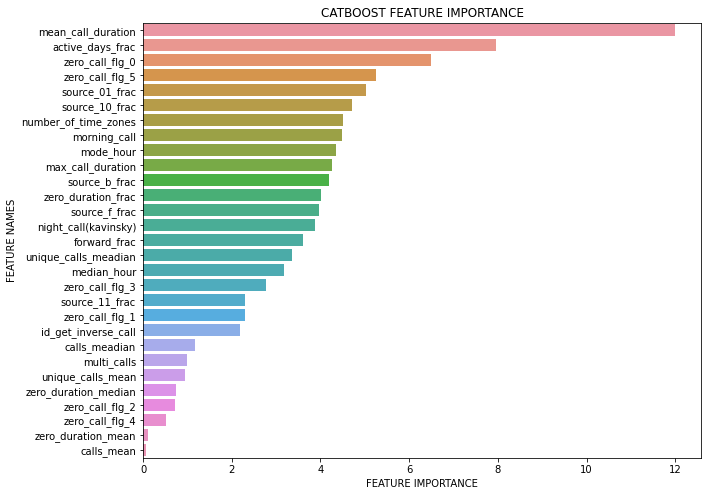

In [180]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.get_feature_importance(),train.columns,'CATBOOST')


In [194]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type)
    plt.xlabel('Взаимная информация')
    plt.ylabel('FEATURE NAMES')

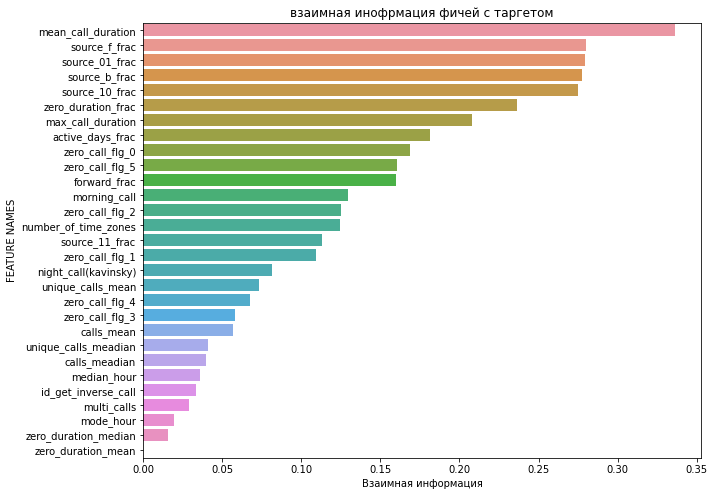

In [196]:
from sklearn.feature_selection import mutual_info_classif
plot_feature_importance(mutual_info_classif(train, y_train), train.columns, 'взаимная инофрмация фичей с таргетом')


**Проверим стабильность нашей модели**

In [259]:
import warnings
warnings.filterwarnings('ignore')

In [260]:
stability_check = pd.read_csv("/content/drive/MyDrive/stability_check_df.csv")

category_columns = ["mode_hour"]

stability_check.drop(columns=["target", "source_00_frac"], inplace=True)
stability_check = stability_check.replace("True", 1)
stability_check = stability_check.replace("False", 0)
stability_check.loc[stability_check.mode_hour.apply(lambda x : len(str(x)) if type(x) != float else 0) > 3, "mode_hour"] = -1

stability_check = stability_check.loc[(stability_check.split == "test") & (~stability_check.unique_calls_meadian.isnull())]

for col in train.columns:
    if train[col].dtype == object:
        stability_check[col] = stability_check[col].astype(float).fillna(0).astype(int)
for col in category_columns:
    stability_check[col] = stability_check[col].fillna(-100).astype(str)

stability_check.drop(columns=["split"], inplace=True)


stability_check["y"] = model.predict(stability_check.drop(columns="id"))
stability_check.id = stability_check.id.map(index2id)
ans["new_target"] = 0
ans.loc[ans.id.isin(stability_check.id), "new_target"] = ans.loc[ans.id.isin(stability_check.id)].id.map(dict(list(zip(stability_check.id, stability_check.y))))
old_y = ans.loc[ans.id.isin(stability_check.id)].target
new_y = ans.loc[ans.id.isin(stability_check.id)].new_target

print("Стабильность алгоритма на кетбусте {}".format(stability_score(old_y, new_y)))


Стабильность алгоритма на кетбусте 0.3612508986340762


**Для сравнения, посмотрим на стабильность knn**

In [263]:
model1 = KNeighborsClassifier(n_neighbors=5)
model1.fit(train, y_train)

stability_check = pd.read_csv("/content/drive/MyDrive/stability_check_df.csv")

category_columns = ["mode_hour"]

stability_check.drop(columns=["target", "source_00_frac"], inplace=True)
stability_check = stability_check.replace("True", 1)
stability_check = stability_check.replace("False", 0)
stability_check.loc[stability_check.mode_hour.apply(lambda x : len(str(x)) if type(x) != float else 0) > 3, "mode_hour"] = -1

stability_check = stability_check.loc[(stability_check.split == "test") & (~stability_check.unique_calls_meadian.isnull())]

for col in train.columns:
    if train[col].dtype == object:
        stability_check[col] = stability_check[col].astype(float).fillna(0).astype(int)
for col in category_columns:
    stability_check[col] = stability_check[col].fillna(-100).astype(str)

stability_check.drop(columns=["split"], inplace=True)


stability_check["y"] = model1.predict(stability_check.drop(columns="id"))
stability_check.id = stability_check.id.map(index2id)
ans["new_target"] = 0
ans.loc[ans.id.isin(stability_check.id), "new_target"] = ans.loc[ans.id.isin(stability_check.id)].id.map(dict(list(zip(stability_check.id, stability_check.y))))
old_y = ans.loc[ans.id.isin(stability_check.id)].target
new_y = ans.loc[ans.id.isin(stability_check.id)].new_target

print("Стабильность алгоритма knn {}".format(stability_score(old_y, new_y)))


Стабильность алгоритма knn 0.6848490294751977


Больше, так что с кетбустом двигаемся в нужную сторону :)

**Посмотрим, что  модель решала для слабоактивных номеров**

In [278]:
data = pd.read_pickle("/content/drive/MyDrive/user_data/data/first_month")
id2_numbers = data.groupby("id_a").id_b.count()

ans = pd.read_csv("/content/beeline_antispam_hakaton_id_samples.csv")

In [292]:
data0, data1, data2, data3, data4 = list(), list(), list(), list(), list()
ys = []
for n in range(2, 30):
    not_so_active = id2_numbers[id2_numbers < n].index.map(index2id)
    temp = ans.loc[(ans.split == "test") & (ans.id.isin(not_so_active))].target.value_counts()
    data0.append(temp[0.0])
    try:
        data1.append(temp[1.0])
    except:
        data1.append(0)
    data2.append(temp[2.0])
    data3.append(temp[3.0])
    data4.append(temp[4.0])
    ys.append(n)

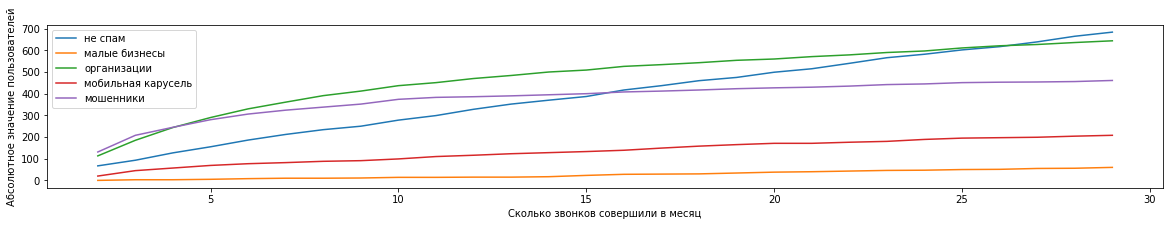

In [306]:
plt.plot(ys, data0, label = "не спам")
plt.plot(ys, data1, label = "малые бизнесы")
plt.plot(ys, data2, label = "организации")
plt.plot(ys, data3, label = "мобильная карусель")
plt.plot(ys, data4, label = "мошенники")
plt.xlabel("Сколько звонков совершили в месяц")
plt.ylabel("Абсолютное значение пользователей")
plt.legend()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

plt.show()

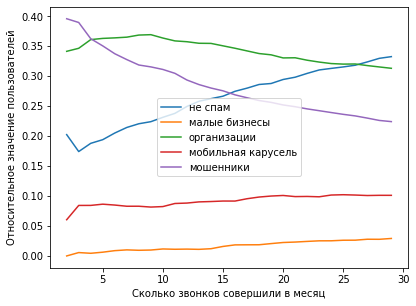

In [308]:
data0, data1, data2, data3, data4 = list(), list(), list(), list(), list()
ys = []
for n in range(2, 30):
    not_so_active = id2_numbers[id2_numbers < n].index.map(index2id)
    temp = ans.loc[(ans.split == "test") & (ans.id.isin(not_so_active))].target.value_counts(normalize=True)
    data0.append(temp[0.0])
    try:
        data1.append(temp[1.0])
    except:
        data1.append(0)
    data2.append(temp[2.0])
    data3.append(temp[3.0])
    data4.append(temp[4.0])
    ys.append(n)

plt.plot(ys, data0, label = "не спам")
plt.plot(ys, data1, label = "малые бизнесы")
plt.plot(ys, data2, label = "организации")
plt.plot(ys, data3, label = "мобильная карусель")
plt.plot(ys, data4, label = "мошенники")
plt.xlabel("Сколько звонков совершили в месяц")
plt.ylabel("Относительное значение пользователей")
plt.legend()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

plt.show()